In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [ ]:

image_directory = "/content/drive/MyDrive/CSE 438/Liver/"
mask_directory = "/content/drive/MyDrive/CSE 438/Liver mask/"

SIZE = 256
image_dataset = []  
mask_dataset = []  

images = os.listdir(image_directory)
masks = os.listdir(mask_directory)

a=masks[0].split('-')
masks2=[]
for i in range (0,len(images)):
      a=images[i].split('-')
      x='segmentaions-'+a[1]
      masks2.append(x)
masks=masks2

for i, image_name in enumerate(images):    
        image = cv2.imread(image_directory+image_name, 0)
        image = image[188:1212,852:1748]
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))


for i, image_name in enumerate(masks):    
        image = cv2.imread(mask_directory+image_name, 0)
        image = image[188:1212,852:1748]
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))


In [ ]:
#%%
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)

mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

print(image_dataset.shape)
print(mask_dataset.shape)

(1271, 256, 256, 1)
(1271, 256, 256, 1)


In [ ]:
#%%
from sklearn.model_selection import train_test_split
X_train, test_x, y_train, test_y = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.10, random_state = 0)
print(X_train.shape)
print(y_train.shape)

(1028, 256, 256, 1)
(1028, 256, 256, 1)


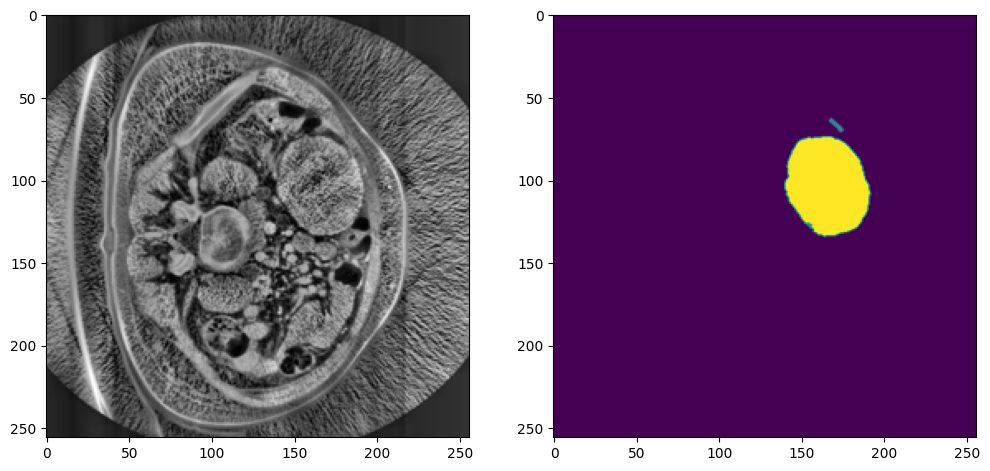

In [ ]:
#%%
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)))
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K

def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = tf.keras.metrics.binary_crossentropy (y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU, Accuracy

################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)  
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    p5 = MaxPooling2D(pool_size=(2, 2))(c5)
    
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
    c6 = Dropout(0.3)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    #Expansive path 
    
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c5])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.3)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c4])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c3])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = concatenate([u10, c2])
    c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    c10 = Dropout(0.1)(c10)
    c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
     
    u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
    u11 = concatenate([u11, c1], axis=3)
    c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
    c11 = Dropout(0.1)(c11)
    c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c11)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coeff])
    model.summary()
    return model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_path = '/content/drive/MyDrive/CSE 438/2_Best_Liver_Det.hdf5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_dice_coeff', verbose=1, save_best_only=True, mode='max')

In [ ]:
#%%
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]


model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

rec = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=200,
                    callbacks=[checkpoint], 
                    validation_data=(X_test, y_test), 
                    shuffle=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 256, 256, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_11 (Dropout)           (None, 256, 256, 16  0           ['conv2d_23[0][0]']              
                                )                                                           

In [ ]:
#%%
#model.save('/content/drive/MyDrive/CSE 438/2_Liver_Det.hdf5')
from tensorflow.keras.models import load_model
model=load_model('/content/drive/MyDrive/CSE 438/2_Best_Liver_Det.hdf5',custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coeff': dice_coeff})

4/4 [==============================] - 0s 26ms/step - loss: 0.1905 - dice_coeff: 0.8496
Accuracy =  84.95970964431763 %


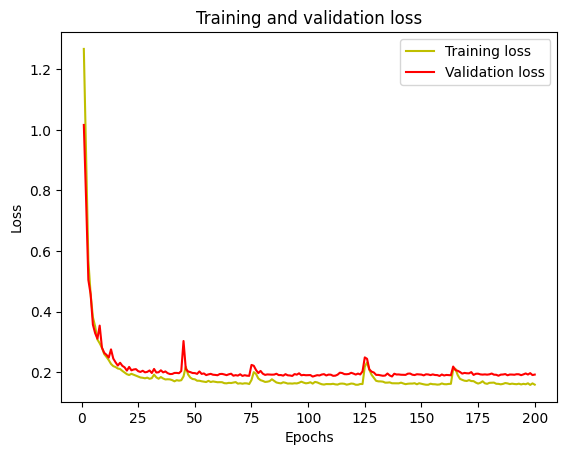

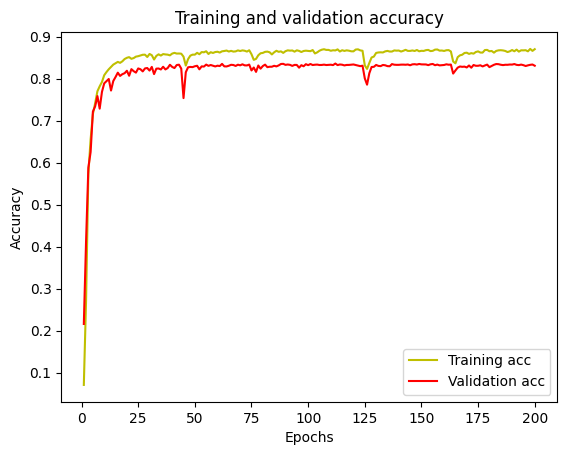

In [ ]:
#%%
_, acc = model.evaluate(test_x, test_y)
print("Accuracy = ", (acc * 100.0), "%")

loss = rec.history['loss']
val_loss = rec.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = rec.history['dice_coeff']
val_acc = rec.history['val_dice_coeff']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#%%
print("\nTraining Accuracy\n")

y_pred=model.predict(X_train)
y_pred_thresholded = y_pred > 0.5

"""IoU Score"""
intersection = np.logical_and(y_train, y_pred_thresholded)
union = np.logical_or(y_train, y_pred_thresholded)
iou_score_tr = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score_tr)

"""Dice Coefficient"""
y_true_f = y_train.flatten()
y_pred_f = y_pred_thresholded.flatten()
intersection = np.sum(y_true_f * y_pred_f)
dice_tr = (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))
print("Dice coefficient is: ", dice_tr)


Training Accuracy

33/33 [==============================] - 1s 21ms/step
IoU socre is:  0.9295788144286526
Dice coefficient is:  0.8797277607887285


In [ ]:
#%%
print("\nValidation Accuracy\n")

y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

"""IoU Score"""
intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score_val = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score_val)

"""Dice Coefficient"""
y_true_f = y_test.flatten()
y_pred_f = y_pred_thresholded.flatten()
intersection = np.sum(y_true_f * y_pred_f)
dice_v = (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))
print("Dice coefficient is: ", dice_v)


Validation Accuracy

4/4 [==============================] - 0s 20ms/step
IoU socre is:  0.9014194945929835
Dice coefficient is:  0.8611757414192539


In [ ]:
#%%
print("\nTesting Accuracy\n")

y_pred=model.predict(test_x)
y_pred_thresholded = y_pred > 0.5

"""IoU Score"""
intersection = np.logical_and(test_y, y_pred_thresholded)
union = np.logical_or(test_y, y_pred_thresholded)
iou_score_tst = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score_tst)

"""Dice Coefficient"""
y_true_f = test_y.flatten()
y_pred_f = y_pred_thresholded.flatten()
intersection = np.sum(y_true_f * y_pred_f)
dice_tst = (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))
print("Dice coefficient is: ", dice_tst)


Testing Accuracy

4/4 [==============================] - 0s 21ms/step
IoU socre is:  0.9109346447578208
Dice coefficient is:  0.8646079522533542


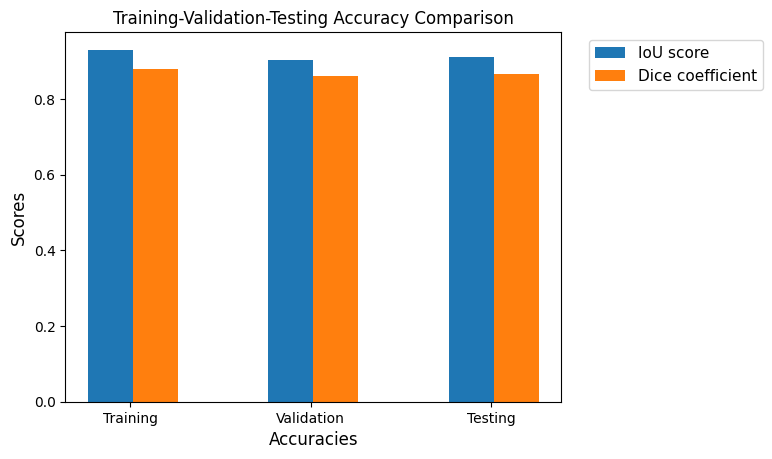

In [ ]:
iou_list=[]
dice_list=[]

iou_list.append(iou_score_tr)
iou_list.append(iou_score_val)
iou_list.append(iou_score_tst)

dice_list.append(dice_tr)
dice_list.append(dice_v)
dice_list.append(dice_tst)

X = ['Training','Validation','Testing']
X_axis = np.arange(len(X))


plt.bar(X_axis + 0.00, iou_list, width = 0.25, label = 'IoU score')
plt.bar(X_axis + 0.25, dice_list, width = 0.25, label = 'Dice coefficient')
 
plt.xticks(X_axis+.11, X, )
plt.xlabel("Accuracies",fontsize=12)
plt.ylabel("Scores",fontsize=12)
plt.title("Training-Validation-Testing Accuracy Comparison")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",fontsize=11, title_fontsize=10)
plt.show()

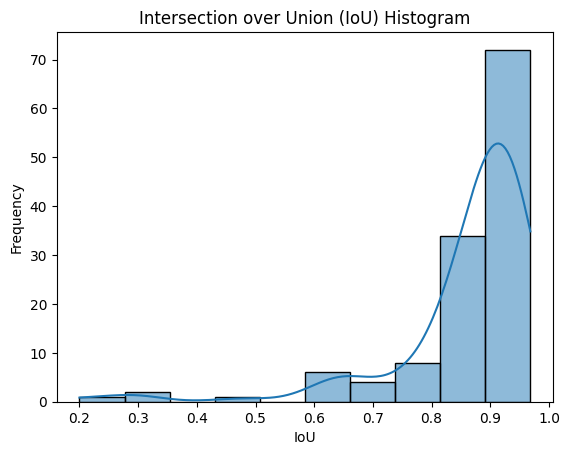

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def generate_iou_histogram(y_true_masks, y_pred_masks, num_bins=10):
    iou_scores = []
    for i in range(len(y_true_masks)):
        iou = calculate_iou(y_true_masks[i], y_pred_masks[i])
        iou_scores.append(iou)

    sns.histplot(iou_scores, bins=num_bins, kde=True)
    plt.xlabel('IoU')
    plt.ylabel('Frequency')
    plt.title('Intersection over Union (IoU) Histogram')
    plt.show()

y_true_masks = test_y
y_pred_masks = y_pred_thresholded

generate_iou_histogram(y_true_masks, y_pred_masks, num_bins=10)


1/1 [==============================] - 0s 21ms/step


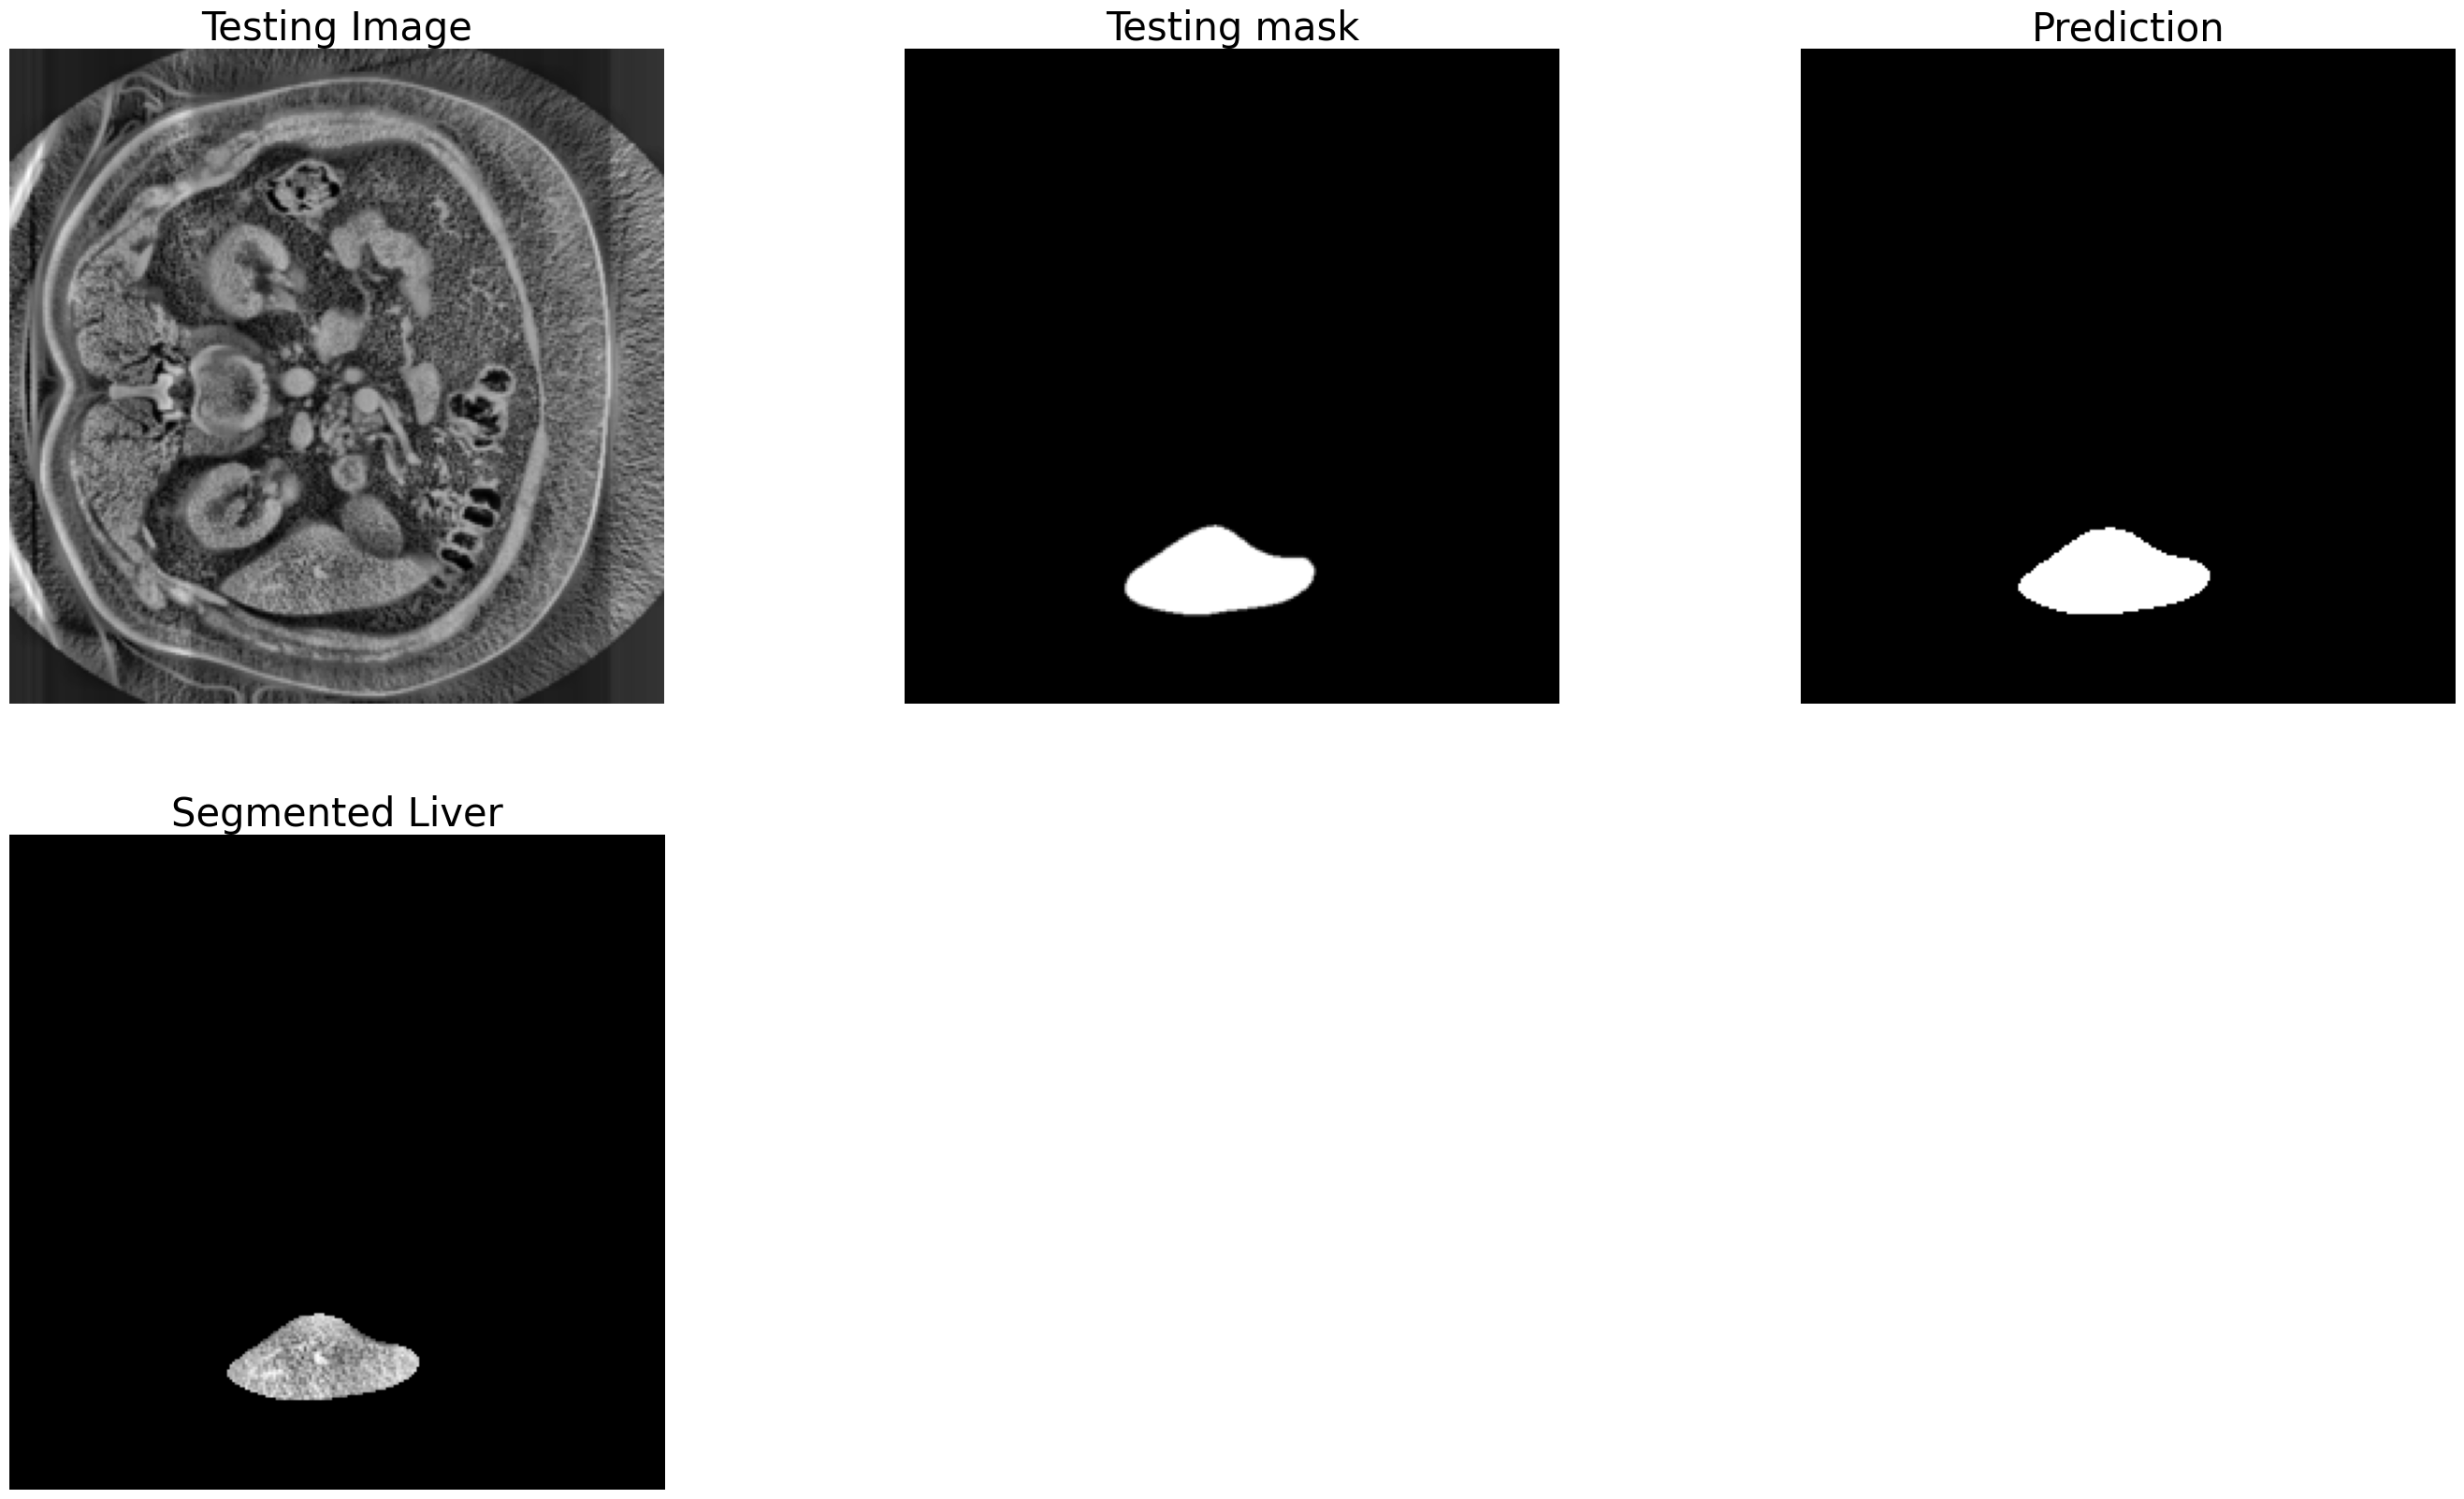

In [ ]:
#%%
import random
import cv2
import numpy as np

test_img_number = random.randint(0, len(test_x))
test_img = test_x[test_img_number]
ground_truth=test_y[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)

prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5)


plt.figure(figsize=(35, 20))
plt.subplot(231)
plt.axis('off')
plt.title('Testing Image',fontsize=30)
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.axis('off')
plt.title('Testing mask',fontsize=30)
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.axis('off')
plt.title('Prediction',fontsize=30)
plt.imshow(prediction, cmap='gray')

image = test_img
mask = prediction
mask = mask.astype(np.uint8)
masked = cv2.bitwise_and(image, image, mask=mask)
plt.subplot(234)
plt.axis('off')
plt.title('Segmented Liver',fontsize=30)
plt.imshow(masked, cmap='gray')


1/1 [==============================] - 0s 21ms/step


<ipython-input-17-8f70be66da6f>:56: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot()


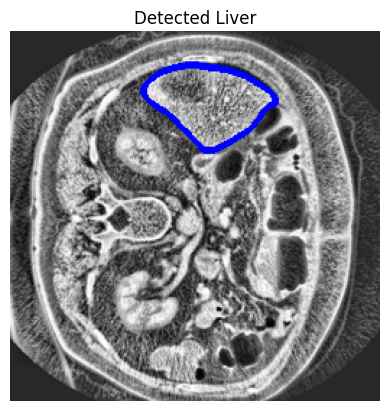

In [ ]:
#%%
import numpy as np
import cv2
import random
import numpy as np

image_directory = "/content/drive/MyDrive/CSE 438/Liver/"
mask_directory = "/content/drive/MyDrive/CSE 438/Liver mask/"

images = os.listdir(image_directory)
masks = os.listdir(mask_directory)

image_number = random.randint(0, len(images))
image_name = images[image_number]
mask_name = masks[image_number]

test_img_other = cv2.imread(image_directory+image_name, 0)
ground_truth = cv2.imread(mask_directory+mask_name, 0)


test_img_other = test_img_other[188:1212,852:1748]
test_img_other = Image.fromarray(test_img_other)
test_img_other = test_img_other.resize((SIZE, SIZE))
test_img_other = np.array(test_img_other)


plt.subplot(231)
plt.axis('off')
plt.title('Image')
plt.imshow(test_img_other, cmap='gray')

test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, 0)

prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.5)


main  = test_img_other
seg = prediction_other
seg = seg.astype(np.uint8)
main = np.stack([main.squeeze()]*3, axis=-1)

contours, _ = cv2.findContours(cv2.convertScaleAbs(seg), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)



for i,c in enumerate(contours):

    mask = np.zeros(seg.shape, np.uint8)
    cv2.drawContours(mask,[c],-1,255, -1)
    mean,_,_,_ = cv2.mean(seg, mask=mask)

    cv2.drawContours(main, [c], -1, (0,0,255), 3)

plt.subplot()
plt.axis('off')
plt.title('Detected Liver')
plt.imshow(main, cmap='gray')